In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/home/joshua/Customer-Segmentation-Project/artifacts/data_ingestion/walmart.csv")

In [3]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


(550068, 10)

In [91]:
print(df["Product_Category"].value_counts())

Product_Category
5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: count, dtype: int64


In [80]:
# Count married vs. single customers
marital_counts = df.drop_duplicates(subset='User_ID')['Gender'].value_counts(normalize=True) * 100
print(marital_counts)

Gender
M    71.719572
F    28.280428
Name: proportion, dtype: float64


In [6]:
#Aggregate Purchase Behavior Features
df_cluster = df.groupby('User_ID').agg(
    total_spent=('Purchase', 'sum'),
    avg_spent=('Purchase', 'mean'),
    purchase_count=('Purchase', 'count'),
    spending_variability=('Purchase', 'std')
).reset_index()

In [7]:
df_cluster = df_cluster.merge(df[['User_ID', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']],
                               on='User_ID', how='left')

In [8]:
df_cluster.head()

,User_ID,total_spent,avg_spent,purchase_count,spending_variability,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status
0,1000001,334093,9545.514286,35,4639.871552,0-17,10,A,2,0
1,1000001,334093,9545.514286,35,4639.871552,0-17,10,A,2,0
2,1000001,334093,9545.514286,35,4639.871552,0-17,10,A,2,0
3,1000001,334093,9545.514286,35,4639.871552,0-17,10,A,2,0
4,1000001,334093,9545.514286,35,4639.871552,0-17,10,A,2,0


In [9]:
age_mapping = {'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
stay_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4+': 4}

df_cluster['Age'] = df_cluster['Age'].map(age_mapping)
df_cluster['Stay_In_Current_City_Years'] = df_cluster['Stay_In_Current_City_Years'].map(stay_mapping)

In [10]:
df_cluster = pd.get_dummies(df_cluster, columns=['City_Category'], prefix='City')
df_cluster.head()

,User_ID,total_spent,avg_spent,purchase_count,spending_variability,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,City_A,City_B,City_C
0,1000001,334093,9545.514286,35,4639.871552,0,10,2,0,True,False,False
1,1000001,334093,9545.514286,35,4639.871552,0,10,2,0,True,False,False
2,1000001,334093,9545.514286,35,4639.871552,0,10,2,0,True,False,False
3,1000001,334093,9545.514286,35,4639.871552,0,10,2,0,True,False,False
4,1000001,334093,9545.514286,35,4639.871552,0,10,2,0,True,False,False


In [11]:
occupation_counts = df_cluster['Occupation'].value_counts(normalize=True)
df_cluster['Occupation_Freq'] = df_cluster['Occupation'].map(occupation_counts)
df_cluster.drop(columns=['Occupation'], inplace=True)
df_cluster.head()

,User_ID,total_spent,avg_spent,purchase_count,spending_variability,Age,Stay_In_Current_City_Years,Marital_Status,City_A,City_B,City_C,Occupation_Freq
0,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506
1,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506
2,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506
3,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506
4,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506


In [12]:
df_product = df.groupby('User_ID').agg(
    top_category=('Product_Category', lambda x: x.value_counts().idxmax()),  # Most purchased category
    unique_categories=('Product_Category', 'nunique')  # Number of unique categories purchased
).reset_index()

In [13]:
df_cluster = pd.merge(df_cluster, df_product, on='User_ID', how='left')
df_cluster.head()

,User_ID,total_spent,avg_spent,purchase_count,spending_variability,Age,Stay_In_Current_City_Years,Marital_Status,City_A,City_B,City_C,Occupation_Freq,top_category,unique_categories
0,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506,3,11
1,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506,3,11
2,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506,3,11
3,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506,3,11
4,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.023506,3,11


In [14]:
print(df_cluster['User_ID'].nunique())  # Should be much smaller than total rows
print(df_cluster.shape)  # Compare total rows vs unique users

5891
(550068, 14)


In [21]:
df_cluster = df_cluster.groupby('User_ID', as_index=False).agg({
    'total_spent': 'sum',       # Total money spent by user
    'avg_spent': 'mean',        # Average spending per transaction
    'purchase_count': 'sum',    # Total number of purchases
    'spending_variability': 'mean',  # Spending consistency
    'Age': 'first',             # Keep first occurrence of Age
    'Stay_In_Current_City_Years': 'first',  # Keep first value
    'Marital_Status': 'first',  # Keep first value
    'City_A': 'first', 'City_B': 'first', 'City_C': 'first',  # One-hot encoded cities
    'Occupation_Freq': 'first',  # Encoded occupation frequency
    'top_category': 'first',     # Most purchased product category
    'unique_categories': 'mean'  # Average unique categories purchased
})


# Extract demographic and categorical data (first occurrence per User_ID)
# df_demographics = df.groupby('User_ID', as_index=False).agg({
#     'Age': 'first',
#     'Stay_In_Current_City_Years': 'first',
#     'Marital_Status': 'first',
# })

# # Merge both datasets
# df_cluster = df_cluster.merge(df_demographics, on='User_ID', how='left')

KeyError: "Column(s) ['Age', 'Marital_Status', 'Stay_In_Current_City_Years'] do not exist"

In [18]:
print(df_cluster['User_ID'].nunique())  # Should be 5891
print(df_cluster.shape)  # Should match (5891, 14)

5891
(550068, 17)


## full code

In [35]:
import pandas as pd

# Step 1: Aggregate Purchase Behavior Features
df_cluster = df.groupby('User_ID').agg(
    total_spent=('Purchase', 'sum'),
    avg_spent=('Purchase', 'mean'),
    purchase_count=('Purchase', 'count'),
    spending_variability=('Purchase', 'std')
).reset_index()

# Merge demographic data (ensuring we take only the first occurrence per User_ID)
df_demographics = df[['User_ID', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']].drop_duplicates('User_ID')
df_cluster = df_cluster.merge(df_demographics, on='User_ID', how='left')

# Step 2: Encoding Categorical Variables
age_mapping = {'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
stay_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4+': 4}

df_cluster['Age'] = df_cluster['Age'].map(age_mapping)
df_cluster['Stay_In_Current_City_Years'] = df_cluster['Stay_In_Current_City_Years'].map(stay_mapping)

# One-hot encoding City_Category
df_cluster = pd.get_dummies(df_cluster, columns=['City_Category'], prefix='City')

# Step 3: Processing Occupation Data
occupation_counts = df_cluster['Occupation'].value_counts(normalize=True)
df_cluster['Occupation_Freq'] = df_cluster['Occupation'].map(occupation_counts)
df_cluster.drop(columns=['Occupation'], inplace=True)

# Step 4: Product Purchase Behavior
df_product = df.groupby('User_ID').agg(
    top_category=('Product_Category', lambda x: x.value_counts().idxmax()),  # Most purchased category
    unique_categories=('Product_Category', 'nunique')  # Number of unique categories purchased
).reset_index()

df_cluster = pd.merge(df_cluster, df_product, on='User_ID', how='left')
# df_cluster = df_cluster.drop("User_ID")
# Step 5: Final Merging & Cleaning
# df_final = df_cluster.copy()  # Already merged and cleaned at this stage


In [36]:
df_cluster.head()

,User_ID,total_spent,avg_spent,purchase_count,spending_variability,Age,Stay_In_Current_City_Years,Marital_Status,City_A,City_B,City_C,Occupation_Freq,top_category,unique_categories
0,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.032592,3,11
1,1000002,810472,10525.610390,77,4301.736734,6,4,0,False,False,True,0.039891,1,6
2,1000003,341635,11780.517241,29,5358.428805,2,3,0,True,False,False,0.023765,1,6
3,1000004,206468,14747.714286,14,5801.640132,4,2,1,False,True,False,0.113563,1,2
4,1000005,821001,7745.292453,106,4110.717354,2,1,1,True,False,False,0.046342,8,12


In [37]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5891 entries, 0 to 5890
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     5891 non-null   int64  
 1   total_spent                 5891 non-null   int64  
 2   avg_spent                   5891 non-null   float64
 3   purchase_count              5891 non-null   int64  
 4   spending_variability        5891 non-null   float64
 5   Age                         5891 non-null   int64  
 6   Stay_In_Current_City_Years  5891 non-null   int64  
 7   Marital_Status              5891 non-null   int64  
 8   City_A                      5891 non-null   bool   
 9   City_B                      5891 non-null   bool   
 10  City_C                      5891 non-null   bool   
 11  Occupation_Freq             5891 non-null   float64
 12  top_category                5891 non-null   int64  
 13  unique_categories           5891 

In [38]:
from sklearn.preprocessing import StandardScaler

# Select numerical features to scale
features_to_scale = ['total_spent', 'avg_spent', 'purchase_count', 
                     'spending_variability', 'Occupation_Freq', 'unique_categories']

# Initialize StandardScaler
scaler = StandardScaler()

# Apply scaling only to numerical features
df_cluster_scaled = df_cluster.copy()
df_cluster_scaled[features_to_scale] = scaler.fit_transform(df_cluster[features_to_scale])

# Display scaled dataset
df_cluster_scaled.head()

,User_ID,total_spent,avg_spent,purchase_count,spending_variability,Age,Stay_In_Current_City_Years,Marital_Status,City_A,City_B,City_C,Occupation_Freq,top_category,unique_categories
0,1000001,-0.562679,-0.012342,-0.544633,-0.258579,0,2,0,True,False,False,-1.108577,3,0.378635
1,1000002,-0.057807,0.506247,-0.152772,-0.649672,6,4,0,False,False,True,-0.917820,1,-1.012150
2,1000003,-0.554686,1.170245,-0.600613,0.572519,2,3,0,True,False,False,-1.339260,1,-1.012150
3,1000004,-0.697937,2.740251,-0.740563,1.085146,4,2,1,False,True,False,1.007492,1,-2.124778
4,1000005,-0.046648,-0.964877,0.117798,-0.870609,2,1,1,True,False,False,-0.749245,8,0.656792


In [39]:
df_cluster_scaled['Stay_In_Current_City_Years'] = pd.to_numeric(df_cluster_scaled['Stay_In_Current_City_Years'], errors='coerce')

In [40]:
# print(df_cluster_scaled.info())  # Ensure all numeric features are properly formatted
print(df_cluster_scaled.describe())  # Check if scaled features are standardized

            User_ID   total_spent     avg_spent  purchase_count  \
count  5.891000e+03  5.891000e+03  5.891000e+03    5.891000e+03   
mean   1.003025e+06  5.910133e-17 -1.736855e-16    5.065828e-17   
std    1.743379e+03  1.000085e+00  1.000085e+00    1.000085e+00   
min    1.000001e+06 -8.672811e-01 -3.836184e+00   -8.152036e-01   
25%    1.001518e+06 -6.648604e-01 -6.781361e-01   -6.286033e-01   
50%    1.003026e+06 -3.643668e-01 -9.663421e-02   -3.673629e-01   
75%    1.004532e+06  2.694388e-01  5.745161e-01    2.204282e-01   
max    1.006040e+06  1.025038e+01  4.766880e+00    8.701413e+00   

       spending_variability          Age  Stay_In_Current_City_Years  \
count          5.891000e+03  5891.000000                 5891.000000   
mean           1.809224e-16     2.620438                    1.858598   
std            1.000085e+00     1.499592                    1.281394   
min           -4.315173e+00     0.000000                    0.000000   
25%           -5.996583e-01     2.00

In [42]:
df_cluster_scaled.drop(columns=['User_ID'], inplace=True)
df_cluster_scaled.head()

,total_spent,avg_spent,purchase_count,spending_variability,Age,Stay_In_Current_City_Years,Marital_Status,City_A,City_B,City_C,Occupation_Freq,top_category,unique_categories
0,-0.562679,-0.012342,-0.544633,-0.258579,0,2,0,True,False,False,-1.108577,3,0.378635
1,-0.057807,0.506247,-0.152772,-0.649672,6,4,0,False,False,True,-0.917820,1,-1.012150
2,-0.554686,1.170245,-0.600613,0.572519,2,3,0,True,False,False,-1.339260,1,-1.012150
3,-0.697937,2.740251,-0.740563,1.085146,4,2,1,False,True,False,1.007492,1,-2.124778
4,-0.046648,-0.964877,0.117798,-0.870609,2,1,1,True,False,False,-0.749245,8,0.656792


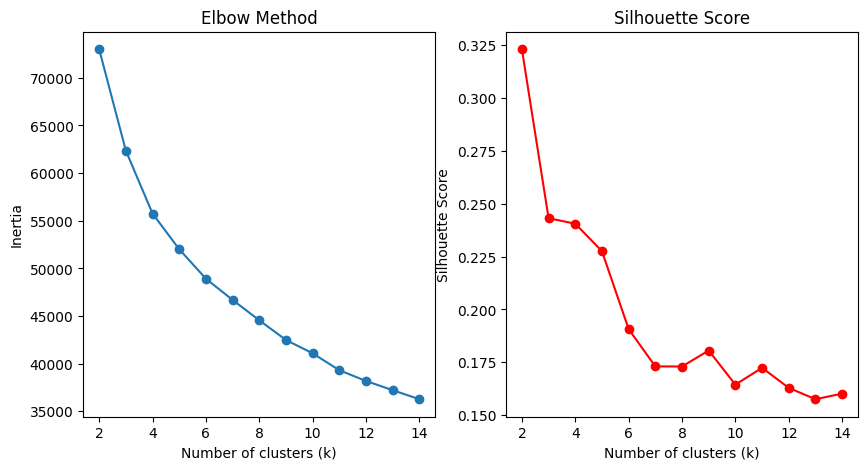

In [43]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different values of k
inertia = []
silhouette_scores = []
K_range = range(2, 15)  # Try k from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_cluster_scaled)
    
    inertia.append(kmeans.inertia_)  # Sum of squared distances
    silhouette_scores.append(silhouette_score(df_cluster_scaled, clusters))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='red')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.show()

In [44]:
from sklearn.cluster import KMeans

# Set the number of clusters
k = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_cluster_scaled['Cluster'] = kmeans.fit_predict(df_cluster_scaled)

# Get cluster labels
cluster_labels = df_cluster_scaled['Cluster']

In [45]:
df_cluster['Cluster'] = cluster_labels

In [46]:
print(df_cluster['Cluster'].value_counts()) 

Cluster
0    2024
1    1843
2    1471
3     553
Name: count, dtype: int64


In [48]:
print(df_cluster.groupby('Cluster').mean()) 

              User_ID   total_spent     avg_spent  purchase_count  \
Cluster                                                             
0        1.003042e+06  8.617179e+05  10975.437476       81.871542   
1        1.003021e+06  5.149953e+05   8628.187343       59.655996   
2        1.003017e+06  5.261682e+05   9133.370895       58.307274   
3        1.002994e+06  2.944965e+06   8713.946870      341.128391   

         spending_variability       Age  Stay_In_Current_City_Years  \
Cluster                                                               
0                 5239.732219  2.481225                    1.858696   
1                 4584.908675  2.467173                    1.880087   
2                 4796.224873  3.106050                    1.836846   
3                 4593.214482  2.349005                    1.844485   

         Marital_Status    City_A    City_B    City_C  Occupation_Freq  \
Cluster                                                                  
0         

In [49]:
df_user_segments = df_cluster[['User_ID', 'Cluster']]
df_user_segments['Segment'] = df_user_segments['Cluster'].map({
    0: 'Frequent Shopper',
    1: 'Power User',
    2: 'Premium Shopper',
    3: 'Young Explorer'
})

# Save to CSV for future use
df_user_segments.to_csv('customer_segments.csv', index=False)

/tmp/ipykernel_148379/102911187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_segments['Segment'] = df_user_segments['Cluster'].map({


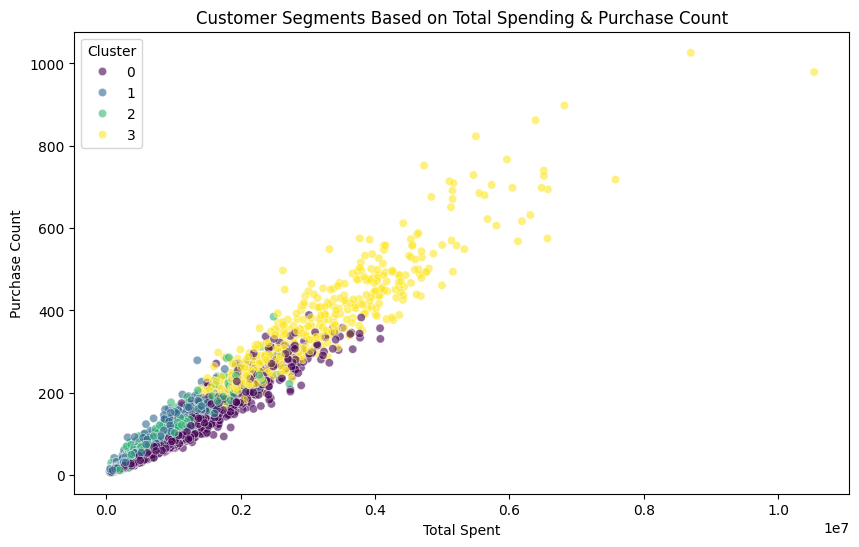

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_cluster['total_spent'], 
    y=df_cluster['purchase_count'], 
    hue=df_cluster['Cluster'], 
    palette='viridis', 
    alpha=0.6
)
plt.title('Customer Segments Based on Total Spending & Purchase Count')
plt.xlabel('Total Spent')
plt.ylabel('Purchase Count')
plt.legend(title='Cluster')
plt.show()

In [51]:
df_cluster.head()

,User_ID,total_spent,avg_spent,purchase_count,spending_variability,Age,Stay_In_Current_City_Years,Marital_Status,City_A,City_B,City_C,Occupation_Freq,top_category,unique_categories,Cluster
0,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.032592,3,11,1
1,1000002,810472,10525.610390,77,4301.736734,6,4,0,False,False,True,0.039891,1,6,0
2,1000003,341635,11780.517241,29,5358.428805,2,3,0,True,False,False,0.023765,1,6,0
3,1000004,206468,14747.714286,14,5801.640132,4,2,1,False,True,False,0.113563,1,2,0
4,1000005,821001,7745.292453,106,4110.717354,2,1,1,True,False,False,0.046342,8,12,2


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features & Target
X = df_cluster.drop(columns=['User_ID', 'Cluster'])
y = df_cluster['Cluster']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the Model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Predict for a new customer
# new_customer = [[500000, 6000, 80, 4000, 2, 1, 0, 0, 0.08, 5, 10]]  # Example input
# predicted_cluster = clf.predict(new_customer)
# print("Predicted Cluster:", predicted_cluster[0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       404
           1       0.98      1.00      0.99       360
           2       1.00      0.98      0.99       296
           3       0.97      0.95      0.96       119

    accuracy                           0.99      1179
   macro avg       0.99      0.98      0.98      1179
weighted avg       0.99      0.99      0.99      1179



In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features & Target
X = df_cluster.drop(columns=['User_ID', 'Cluster'])
y = df_cluster['Cluster']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the Model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Ensure the new customer input matches the feature columns
new_customer = pd.DataFrame([{
    'total_spent': 821001,
    'avg_spent': 7745.292453,
    'purchase_count': 106,
    'spending_variability': 4110.717354,
    'Age': 2,
    'Stay_In_Current_City_Years': 1,
    'Marital_Status': 1,
    'City_A': 1,  # Ensure one-hot encoding matches
    'City_B': 0,
    'City_C': 0,
    'Occupation_Freq': 0.046342,
    'top_category': 8,
    'unique_categories': 12
}])

# Predict the segment
predicted_cluster = clf.predict(new_customer)
print("Predicted Cluster:", predicted_cluster[0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       404
           1       0.98      1.00      0.99       360
           2       1.00      0.98      0.99       296
           3       0.97      0.95      0.96       119

    accuracy                           0.99      1179
   macro avg       0.99      0.98      0.98      1179
weighted avg       0.99      0.99      0.99      1179

Predicted Cluster: 2


In [60]:
correlation = df_cluster[['Stay_In_Current_City_Years', 'Occupation_Freq']].corr()
print(correlation)

                            Stay_In_Current_City_Years  Occupation_Freq
Stay_In_Current_City_Years                    1.000000         0.012998
Occupation_Freq                               0.012998         1.000000


/tmp/ipykernel_148379/2903472998.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette="viridis")


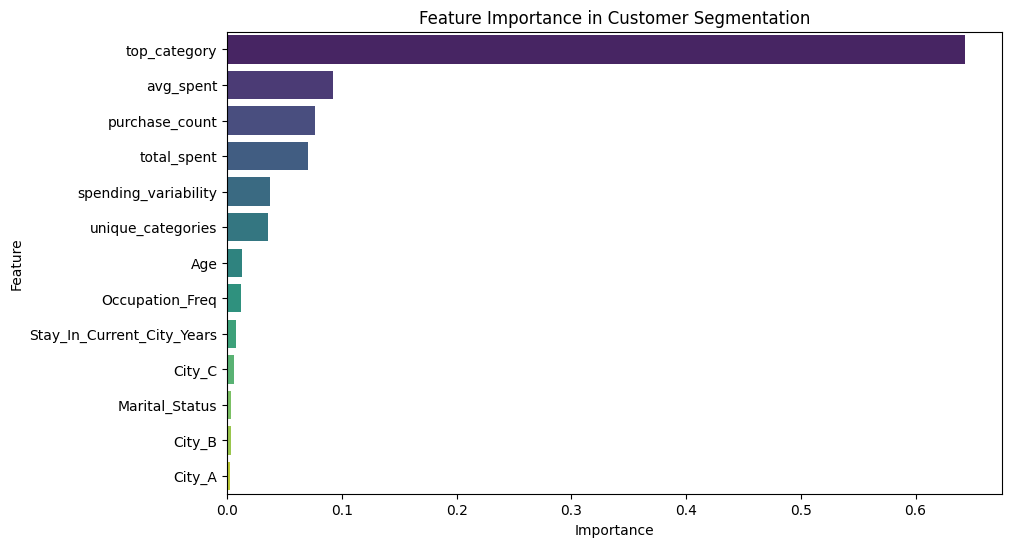

In [61]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Train a random forest model (assuming you have X_train, y_train)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette="viridis")
plt.title("Feature Importance in Customer Segmentation")
plt.show()

## updated features

In [63]:
features_to_keep = ['total_spent', 'avg_spent', 'purchase_count', 
                    'spending_variability', 'top_category', 
                    'unique_categories', 'Occupation_Freq', 'Age']

In [64]:
from sklearn.preprocessing import StandardScaler

# Keep only selected features
df_selected = df_cluster[features_to_keep].copy()

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

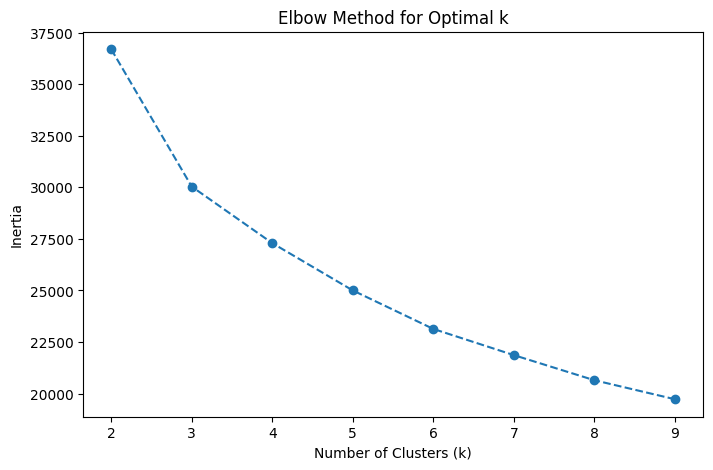

In [65]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Test different values of k
inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

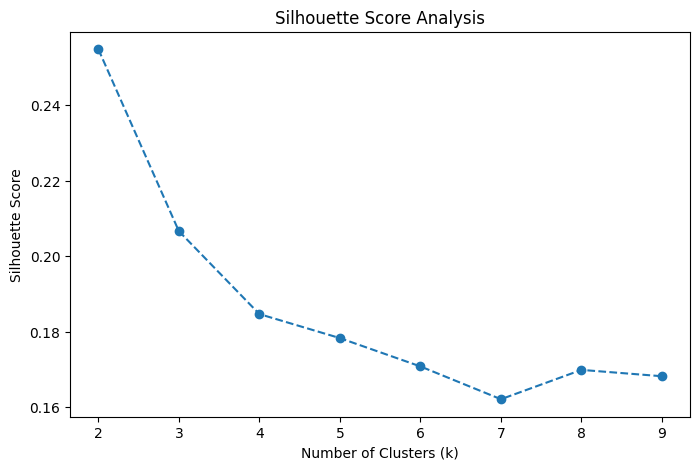

In [66]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, cluster_labels))

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis')
plt.show()

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select refined features
features_to_keep = ['total_spent', 'avg_spent', 'purchase_count', 
                    'spending_variability', 'top_category', 
                    'unique_categories', 'Occupation_Freq', 'Age']

# Standardize only the selected features
scaler = StandardScaler()
df_cluster_scaled = df_cluster[features_to_keep].copy()
df_cluster_scaled[features_to_keep] = scaler.fit_transform(df_cluster_scaled[features_to_keep])

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster_scaled['Cluster'] = kmeans.fit_predict(df_cluster_scaled)

# Assign refined clusters back to df_cluster
df_cluster['Cluster'] = df_cluster_scaled['Cluster']

# Display new cluster counts
print(df_cluster['Cluster'].value_counts())

# Check new cluster characteristics
print(df_cluster.groupby('Cluster').mean())

Cluster
1    1876
3    1557
0    1446
2    1012
Name: count, dtype: int64
              User_ID   total_spent     avg_spent  purchase_count  \
Cluster                                                             
0        1.003006e+06  5.353735e+05   9483.458543       56.961964   
1        1.003078e+06  6.186997e+05  11271.632932       55.440299   
2        1.003031e+06  2.513308e+06   9057.815390      282.030632   
3        1.002975e+06  3.966054e+05   7928.620631       50.276172   

         spending_variability       Age  Stay_In_Current_City_Years  \
Cluster                                                               
0                 5115.247443  3.813278                    1.876210   
1                 5388.077271  2.295842                    1.881130   
2                 4703.642950  2.355731                    1.842885   
3                 4101.304862  2.075787                    1.825305   

         Marital_Status    City_A    City_B    City_C  Occupation_Freq  \
Cluster   

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select refined features
features_to_keep = ['total_spent', 'avg_spent', 'purchase_count', 
                    'spending_variability', 'top_category', 
                    'unique_categories', 'Occupation_Freq', 'Age']

# Standardize only the selected features
scaler = StandardScaler()
df_cluster_scaled = df_cluster[features_to_keep].copy()
df_cluster_scaled[features_to_keep] = scaler.fit_transform(df_cluster_scaled[features_to_keep])

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster_scaled['Cluster'] = kmeans.fit_predict(df_cluster_scaled)

# Assign refined clusters back to df_cluster
df_cluster['Cluster'] = df_cluster_scaled['Cluster']

# Display new cluster counts
print(df_cluster['Cluster'].value_counts())

# Check new cluster characteristics
print(df_cluster.groupby('Cluster').mean())

Cluster
1    1876
3    1557
0    1446
2    1012
Name: count, dtype: int64
              User_ID   total_spent     avg_spent  purchase_count  \
Cluster                                                             
0        1.003006e+06  5.353735e+05   9483.458543       56.961964   
1        1.003078e+06  6.186997e+05  11271.632932       55.440299   
2        1.003031e+06  2.513308e+06   9057.815390      282.030632   
3        1.002975e+06  3.966054e+05   7928.620631       50.276172   

         spending_variability       Age  Stay_In_Current_City_Years  \
Cluster                                                               
0                 5115.247443  3.813278                    1.876210   
1                 5388.077271  2.295842                    1.881130   
2                 4703.642950  2.355731                    1.842885   
3                 4101.304862  2.075787                    1.825305   

         Marital_Status    City_A    City_B    City_C  Occupation_Freq  \
Cluster   

In [70]:
df_cluster.head()

,User_ID,total_spent,avg_spent,purchase_count,spending_variability,Age,Stay_In_Current_City_Years,Marital_Status,City_A,City_B,City_C,Occupation_Freq,top_category,unique_categories,Cluster
0,1000001,334093,9545.514286,35,4639.871552,0,2,0,True,False,False,0.032592,3,11,1
1,1000002,810472,10525.610390,77,4301.736734,6,4,0,False,False,True,0.039891,1,6,0
2,1000003,341635,11780.517241,29,5358.428805,2,3,0,True,False,False,0.023765,1,6,1
3,1000004,206468,14747.714286,14,5801.640132,4,2,1,False,True,False,0.113563,1,2,1
4,1000005,821001,7745.292453,106,4110.717354,2,1,1,True,False,False,0.046342,8,12,3


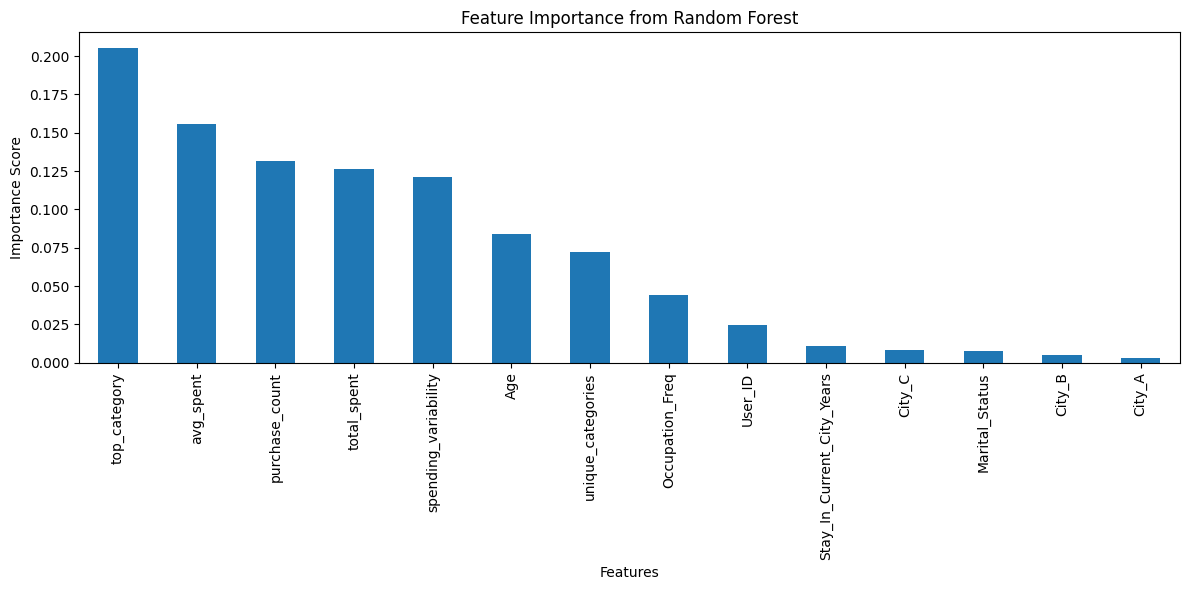

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_cluster is your prepared dataset with cluster labels
# Separate features and target
X = df_cluster.drop(['Cluster'], axis=1)  # Drop target
y = df_cluster['Cluster']  # Clusters as target

# Split the data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

# Retrain without 'Gender' to compare impact
# if 'Gender' in X.columns:
#     X_no_gender = X.drop('Gender', axis=1)
#     X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(X_no_gender, y, test_size=0.2, random_state=42)
    
#     rf_ng = RandomForestClassifier(n_estimators=100, random_state=42)
#     rf_ng.fit(X_train_ng, y_train_ng)
    
#     feature_importances_ng = pd.Series(rf_ng.feature_importances_, index=X_no_gender.columns)
#     feature_importances_ng = feature_importances_ng.sort_values(ascending=False)
    
#     # Visualize feature importances without Gender
#     plt.figure(figsize=(12, 6))
#     feature_importances_ng.plot(kind='bar')
#     plt.title('Feature Importance Without Gender')
#     plt.xlabel('Features')
#     plt.ylabel('Importance Score')
#     plt.tight_layout()
#     plt.show()